In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import pandas_datareader.data as web
import yfinance as yf

In [5]:
start = '2010-01-01'
end = '2023-05-18'
df = yf.download("^NSEI", start, end)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-11,18357.800781,18389.699219,18270.400391,18297.000000,18297.000000,248900
2023-05-12,18273.750000,18342.750000,18194.550781,18314.800781,18314.800781,241700
2023-05-15,18339.300781,18458.900391,18287.900391,18398.849609,18398.849609,216100
2023-05-16,18432.349609,18432.349609,18264.349609,18286.500000,18286.500000,219500
2023-05-17,18300.449219,18309.000000,18115.349609,18181.750000,18181.750000,229900


In [7]:
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [8]:
df = df.drop(['Date', 'Adj Close'], axis = 1)   ##Dropping unwanted cols
df.head()

,Open,High,Low,Close,Volume
0,5200.899902,5238.450195,5167.100098,5232.200195,0
1,5277.149902,5288.350098,5242.399902,5277.899902,0
2,5278.149902,5310.850098,5260.049805,5281.799805,0
3,5281.799805,5302.549805,5244.750000,5263.100098,0
4,5264.250000,5276.750000,5234.700195,5244.750000,0


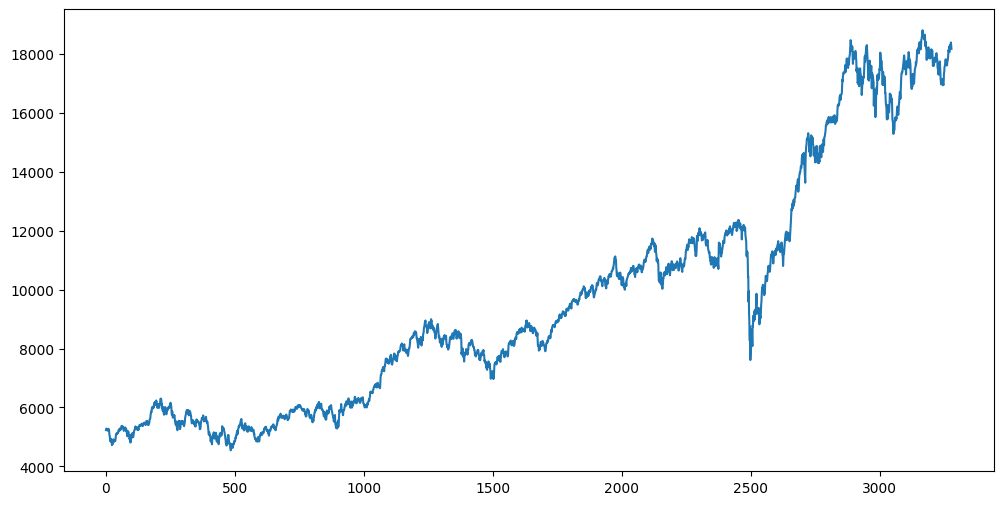

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(df.Close)

In [10]:
df.shape

(3280, 5)

In [11]:
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.80)])

data_testing = pd.DataFrame(df['Close'][int(len(df)*0.80): int(len(df))])

In [12]:
print(data_training.shape), print(data_testing.shape)

(2624, 1)
(656, 1)


(None, None)

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [30]:
data_training_array = scaler.fit_transform(data_training)

In [44]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [45]:
past_100_days = data_training.tail(100)

In [46]:
final_df = pd.concat([past_100_days, data_testing])

In [47]:
input_data = scaler.fit_transform(final_df)

In [48]:
x_test = []
y_test = []

test_data = df['Close']
test_data_array = test_data.to_numpy()
test_data_array = scaler.fit_transform(test_data_array.reshape(-1,1))

for i in range(100, test_data_array.shape[0]):
    x_test.append(test_data_array[i-100: i])
    y_test.append(test_data_array[i])

In [49]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [51]:
from tensorflow import keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
model = Sequential()
model.add(LSTM(units = 100, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) 

model.add(LSTM(units = 67, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 45, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 29, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

In [53]:
early_stop = EarlyStopping(monitor = "loss", verbose = 1, mode = 'min', patience = 3)

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, epochs = 50, validation_data = (x_test,y_test), callbacks=[early_stop])

Epoch 1/50
79/79 [==============================] - 29s 272ms/step - loss: 0.1297 - val_loss: 0.0050
Epoch 2/50
79/79 [==============================] - 19s 245ms/step - loss: 0.0280 - val_loss: 0.0075
Epoch 3/50
79/79 [==============================] - 20s 252ms/step - loss: 0.0230 - val_loss: 0.0058
Epoch 4/50
79/79 [==============================] - 21s 267ms/step - loss: 0.0190 - val_loss: 0.0024
Epoch 5/50
79/79 [==============================] - 20s 260ms/step - loss: 0.0183 - val_loss: 0.0033
Epoch 6/50
79/79 [==============================] - 20s 257ms/step - loss: 0.0156 - val_loss: 0.0031
Epoch 7/50
79/79 [==============================] - 20s 253ms/step - loss: 0.0149 - val_loss: 0.0025
Epoch 8/50
79/79 [==============================] - 20s 257ms/step - loss: 0.0139 - val_loss: 0.0033
Epoch 9/50
79/79 [==============================] - 21s 263ms/step - loss: 0.0129 - val_loss: 0.0032
Epoch 10/50
79/79 [==============================] - 20s 260ms/step - loss: 0.0126 - val_lo

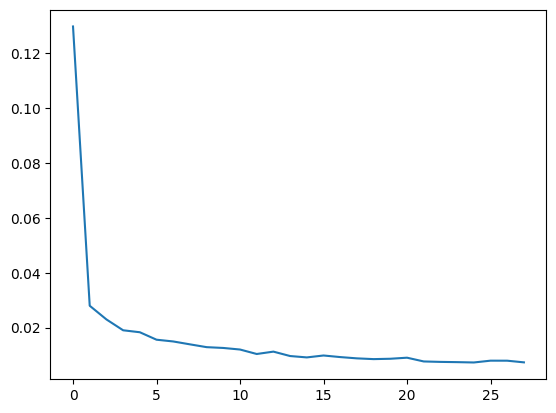

In [54]:
loss = model.history.history['loss']
plt.plot(loss)

In [55]:
y_predicted = model.predict(x_test)

100/100 [==============================] - 7s 57ms/step


In [56]:
y_predicted.shape

(3180, 1)

In [57]:
y_test

array([[0.0298564 ],
       [0.03333613],
       [0.03968937],
       ...,
       [0.97100913],
       [0.96313506],
       [0.95579361]])

In [58]:
y_predicted

array([[0.0716691 ],
       [0.07131949],
       [0.07109204],
       ...,
       [0.8907019 ],
       [0.8928508 ],
       [0.89497465]], dtype=float32)

In [59]:
y_predicted = scaler.inverse_transform(y_predicted)
y_test = scaler.inverse_transform(y_test)

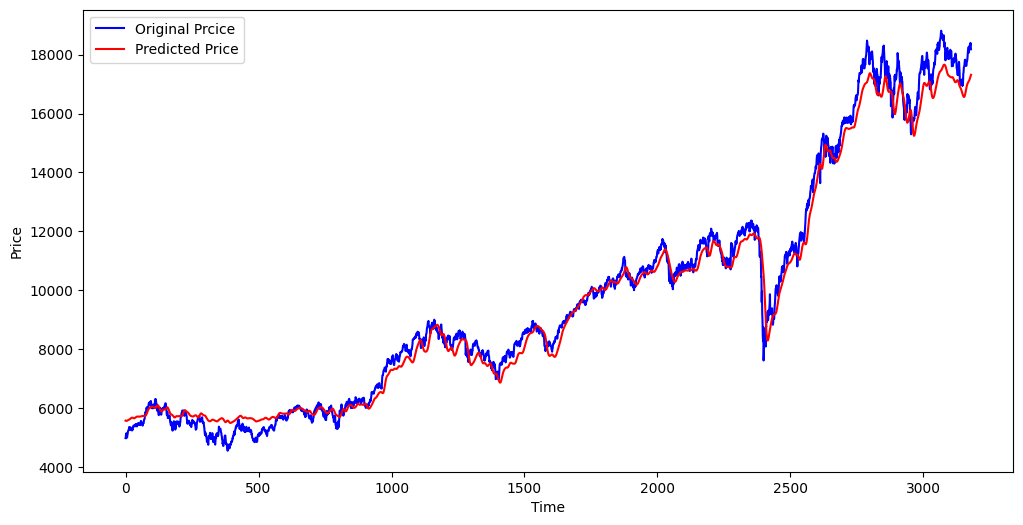

In [60]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = 'Original Prcice')
plt.plot(y_predicted, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [61]:
x_train.shape , y_test.shape

((2524, 100, 1), (3180, 1))

In [62]:
a = data_testing.tail(100)
a_array = scaler.fit_transform(a)
fut_inp = a_array.reshape(1,-1)
tmp_inp = list(fut_inp[0])

In [63]:
len(tmp_inp)

100

In [64]:
lst_output = list()
n_steps = 100
i = 0
while(i<31): 
    if(len(tmp_inp) > 100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp = fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose = 0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp,verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat[0].tolist())
        i=i+1
        
print(lst_output)

[0.7373536825180054, [0.7591480016708374], [0.7773979902267456], [0.790926992893219], [0.7992825508117676], [0.8025964498519897], [0.8015568256378174], [0.7970331907272339], [0.7901301383972168], [0.7820041179656982], [0.7736138105392456], [0.76566481590271], [0.7585576772689819], [0.7524389028549194], [0.747344970703125], [0.7432126998901367], [0.7399167418479919], [0.7372957468032837], [0.735180139541626], [0.7334115505218506], [0.731856107711792], [0.7304096221923828], [0.7289987802505493], [0.7275773286819458], [0.7261220216751099], [0.7246257662773132], [0.723092794418335], [0.7215331792831421], [0.7199594974517822], [0.7183840274810791], [0.7168170213699341]]


In [65]:
len(lst_output)

31

In [66]:
final_output = []

In [67]:
for i in range(1,31) :
    final_output.append(lst_output[i][0])

In [68]:
final_output2 = np.array(final_output)

In [69]:
final_output2 = final_output2.reshape(-1,1)

In [70]:
final_output2.shape

(30, 1)

In [71]:
final_output3 = scaler.inverse_transform(final_output2)

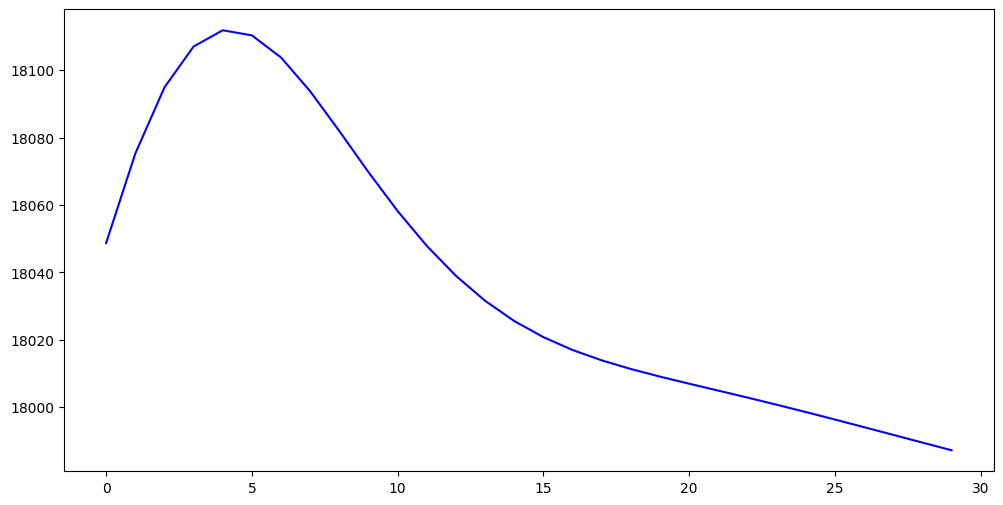

In [72]:
plt.figure(figsize = (12,6))
plt.plot(final_output3, 'b', label = 'Original Prcice')

In [73]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print('R2 Score: ', r2_score(y_test, y_predicted))
print('MAE: ', mean_absolute_error(y_test, y_predicted))

R2 Score:  0.9866676539351716
MAE:  355.0725788620283
